In [1]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

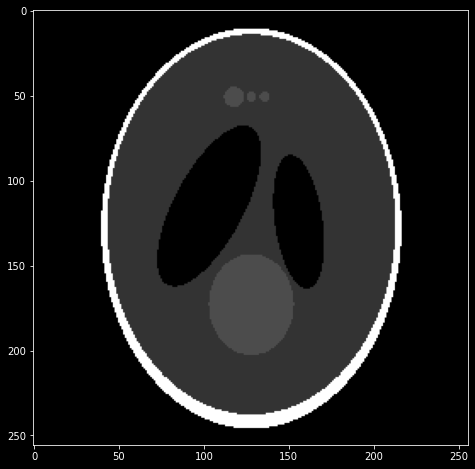

In [2]:
phantom = sigpy.shepp_logan((256, 256))
rows, cols = phantom.shape
_ = plt.imshow(np.abs(phantom), cmap="gray")

0.0791168212890625

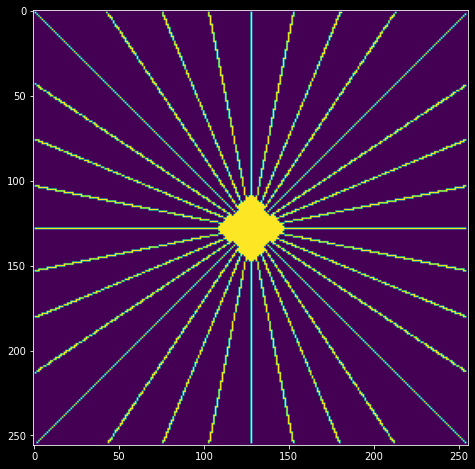

In [3]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 32, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]
b = np.fft.fft2(phantom).flatten()[samples_rows]

get_proportion(phantom.flatten(), b)
_ = plt.imshow(np.fft.fftshift(radial_mask))

In [5]:
# from scipy.io import savemat

# phantom = {"phantom": phantom}
# b = {"b": b}
# samples_rows = {"samples_rows": samples_rows}

# savemat("samples_rows.mat", samples_rows)
# savemat("b.mat", b)
# savemat("phantom.mat", phantom)

PSNR: 18.721172651106553
SSIM: 0.30438127746616445
SNR: 6.590090835878178
MSE: 0.013424024462264846


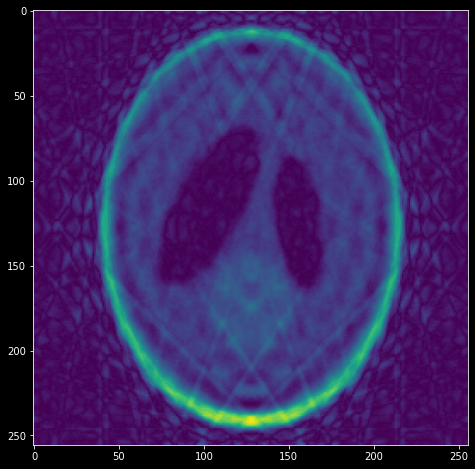

In [4]:
zero_filled = zero_fill(b, samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = calculate_metrics(np.abs(phantom), np.abs(zero_filled))

# No prior information LP minimization

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 19.027833700180054s


PSNR: 30.27875378348714
SSIM: 0.8234194401565108
SNR: 18.147671968258766
MSE: 0.0009378310807819102


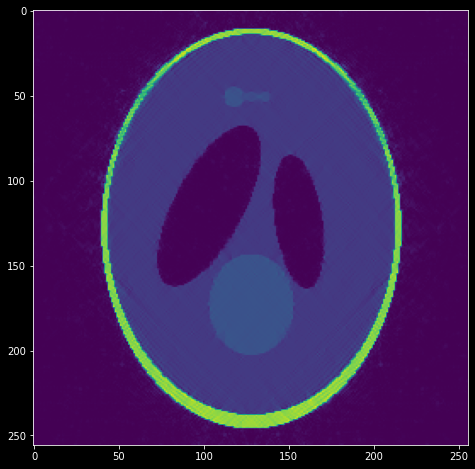

In [77]:
import mri_cs
reload(mri_cs)

filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]
rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

nopi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(nopi_recon))

# Transposing filters to fix filter transpose in lp minimization

In [130]:
phi = mri_cs.prior_information(np.abs(phantom), pi_prop=3.5/100, filters=filters)
phi

[array([62575, 61282, 61089, ..., 60330, 46688, 52453]),
 array([52798, 43822, 26070, ..., 48082, 31673, 60069]),
 array([58798, 44078, 61025, ..., 34655, 62262, 39769])]

In [68]:
def create_mask(samples_rows, rows=256, cols=256, transpose=False):
    mask = np.zeros((rows * cols), dtype=int)
    mask[samples_rows] = 1
    mask = np.reshape(mask, (rows, cols))
    if transpose:
        mask = mask.T
    return mask

# Visualizing prior information leveraged

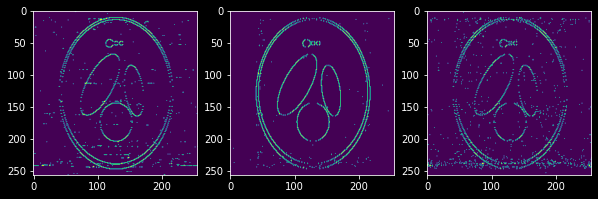

In [112]:
phi = prior_information(np.abs(phantom), pi_prop=3.5/100, filters=filters)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
_ = ax1.imshow(create_mask(test_phi[0]))
_ = ax2.imshow(create_mask(test_phi[1]))
_ = ax3.imshow(create_mask(test_phi[2]))

# LP Minimization with pre filtering and prior information

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 16.448230981826782s
PSNR: 78.23070737823501
SSIM: 0.9999908143709146
SNR: 66.09962556300664
MSE: 1.5028971544781564e-08


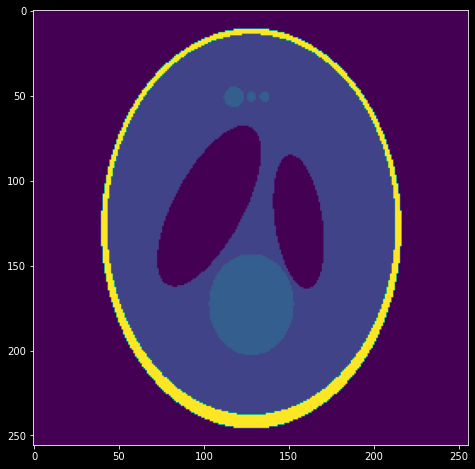

In [131]:
import mri_cs
reload(mri_cs)

rows, cols = phantom.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

pi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                               p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                               number_jobs=1, maxiterperstage=maxiterperstage,
                               phi=phi, tau=tau, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(phantom), np.abs(pi_recon))